Version notes:
- value-weighting
- cross-validation
- plots and charts
- try other bond characteristics

# ML Analysis

In [1]:
import pandas as pd
import numpy as np

## Data
Data are from 'data_cleaning.ipynb', which uses a subset of merged TRACE and Mergent FISD daily bond data. It follows the sample exclusion criteria of Bai, Bali & Wen (2019) and aggregates returns to monthly based on their methodologies.

Following Moritz and Zimmerman (2016) (MZ), the goal is to estimate the expected return of stock i in time period t+1, conditional on information in period t.

In the context of corporate bonds, our aim will be to predict the return of bond i. Then based on the predicted return for t+1, bonds are sorted into deciles based on the expected return, and the trading strategy goes long the top decile (ie. highest predicted returns) and short the bottom decile. The out-of-sample test is implemented on a rolling basis: the model is estimated every year, using data from the past 5 years. Returns are predicted for the next 12 months, and in each month the decile portfolio strategy is implemented.

Given the bond characteristics, such as credit rating, duration, and yield-to-maturity (which are all known factors to affect returns), three types of return models can be implemented. The first can focus on raw returns, the second could focus on returns in "excess" of these other factors, and the third can incorporate these characteristics and return-based factors simultaneously. The first model ignores potential correlation between the return-based factors and other bond characteristics, however it follows Moritz and Zimmerman's methodology. The second model would involve first orthogonalizing returns to the bond factors (using linear regression), and then predicting the residual returns; this is appealing, but introduces estimation uncertainty (ie. what if the relationship is non-linear). Lastly, the third methodology is the most flexible. For example, it may be optimal to first sort on duration, and then on past returns etc. 


Thus, the outcome variables (ie. to be predicted) is the next month's return, up to the next 11 months. ~~To simplify things, it may be worthwhile to consider a buy-and-hold strategy: estimate the model, predict the next cummulative X month return (say 3 or 12 months), sort stocks, and go long/sort the portfolios with a holding period of X months. This would have significantly less turnover and hence less transaction costs. This could be used as a robustness check.~~ (This is impractical data wise)

The predictor variables are the past 24 months of 1 month returns (ie. the return over month t-k to t-k+1 for k = (1,...24)). The notation used by Moritz and Zimmerman is $ R_{i,t}(k,1) $. Thus the tree-based model effectively estimates a more complicated version of:

$
r_{i,t+1} = \mu_{1t} I(R_{i,t}(k,1) \lt \tau_t) + \mu_{2t} I(R_{i,t}(k,1) \ge \tau_t)
$

Where $\mu_1t$ can be interpreted as the return on a portfolio for which all stocks $i$ satisfy $R_{i,t}(k,1) \lt \tau_t$ in period $t$. Hence instead of simply sorting on a particular decile, stocks are sorted deeply on potentially many different criteria.

In terms of implementation practicicality, the ML model can be estimated akin to the Fama-MacBeth procedure. Using the past 5 years (60 months) of data, predictions can be formed. The estimation is over the time-dimension (in an OLS framework equivalent to averaging the results of 60 cross-sectional regressions), while the prediction is over the cross-sectional dimension (ie. bonds are ranked by highest return in the next cross-section). 

Hence the data should be indexed at the bond-month level (ie. all predictors and outcomes should be aligned to month t for bond i). Thus estimating a model for bond i using data from t-60 to t is equivalent to a pooled cross-section. 

In [2]:
data = pd.read_csv('monthly_data.csv', index_col=0)

In [3]:
data.head()

,date,issue_id,cusip_id,volume,issuer_id,prospectus_issuer_name,maturity,offering_amt,interest_frequency,cusip,...,rating_spr,rating_mdy,amount_outstanding,tau,age,ytm,duration,tr_dirty_price,tr_ytm,return
0,2002-08-31,98694,010392DN5,25000.0,86.0,ALABAMA PWR CO,2004-08-15,250000.0,2.0,010392DN5,...,A,A2,250000.0,1.972603,3.038356,3.672086,1.872172,109.77133,2.142072,-0.024568
1,2002-08-31,99961,010392DP0,15000.0,86.0,ALABAMA PWR CO,2007-10-01,200000.0,2.0,010392DP0,...,A,A2,200000.0,5.101370,2.931507,4.540522,4.299664,120.46437,3.339660,0.013677
2,2002-08-31,144179,00079FAW2,20000.0,37284.0,ABN AMRO BK N V,2003-12-19,4500.0,2.0,00079FAW2,...,AA,Aa2,4500.0,1.315068,0.200000,12.814093,1.230101,115.34654,1.844255,0.006316
3,2002-08-31,97686,013104AE4,215000.0,93.0,ALBERTSONS INC,2009-08-01,350000.0,2.0,013104AE4,...,BBB+,Baa1,350000.0,6.936986,3.098630,5.601379,5.647303,119.27208,3.834566,-0.001913
4,2002-08-31,102864,029050AB7,2000000.0,33708.0,AMERICAN PLUMBING & MECHANICAL,2008-10-15,125000.0,2.0,029050AB7,...,B-,B3,125000.0,6.142466,2.734246,29.812586,3.527641,148.25096,3.569999,0.012265


## Summary Stats

In [4]:
# Chronological order, indexes by month-bond
data = data.sort_values(by=['date', 'issue_id'])
data = data.set_index(['date', 'issue_id'])

In [5]:
print('There are', len(data.index.get_level_values(0).unique()), ' unique months in the panel')

There are 234  unique months in the panel


In [6]:
bond_count = {}
for month in data.index.get_level_values(0).unique():
    bond_count[month] = len(data.loc[month])

bonds = pd.DataFrame.from_dict(bond_count, orient='index', columns=['Bond Count'])

In [7]:
print('There are on average ', bonds.describe().loc['mean'][0].astype(int), 
      ' bonds in each monthly cross-section, with as few as ', bonds.describe().loc['min'][0], 
      ' and as many as ', bonds.describe().loc['max'][0])

There are on average  373  bonds in each monthly cross-section, with as few as  190.0  and as many as  594.0


## Outcome-Predictor Organization

Since predictors and outcomes are both returns, the notation will follow from MZ, where predictors will be denoted as R(k,1) (ie. the historical 1 month return for month k), while the outcome will be denoted as r(k,t) (ie. the t-month cummulative return of holding the bond k months ahead). As mentioned previously, the main outcomes will be {r(1,1),...,r(12,1)} ~~as well as {r(1,3),r(1,12)}.~~

In [8]:
# Risk-free rate
crsp_data = pd.read_csv("crsp_data.csv", index_col='MthCalDt', parse_dates=True)
crsp_data = crsp_data.pivot(columns="IndNm", values='COL1')
crsp_data.index = crsp_data.index + pd.tseries.offsets.MonthEnd(0)
crsp_data.columns = ['20y_return', 'rf', '30y_return', '90day', 'mkt']
crsp_data.index.name = 'Date'

risk_free = crsp_data['rf'].loc[data.index[0][0]:data.index[-1][0]]

In [9]:
df = data.copy().reset_index()

In [10]:
# Excess Returns
df['excess_return'] = df['return'] - df.groupby('date')['date'].transform(lambda x: risk_free.loc[x.iloc[0]])
df = df.set_index(['date', 'issue_id'])

In [11]:
# Predictors: Past 1-month Returns
for i in range(24):
    df['R('+str(i)+',1)'] = df.groupby(level=1)['excess_return'].shift(i+1)

In [12]:
# Outcomes:
# 12 months of 1-month returns
for i in range(12):
    df['r('+str(i+1)+',1)'] = df.groupby(level=1)['excess_return'].shift(-(i+1))

In [13]:
# df.to_csv('model_data.csv')

## Model Estimation

Several models can be implemented. 

1) OLS
- All 24 past returns can be used as predictors

~~2) Regularization~~
- ~~Same predictors as OLS, but can include all combinations of 2 or 3 way interactions~~
- ~~LASSO seems like an obvious candidate~~

3) Regression Tree
- Can be used to demonstrate the underlying mechanics and interpretation
- Will likely overfit, but still worthwhile to implement

4) Random Forest
- Follows from MZ

5) XGBoost
6) Neural Network???

Regardless of which model is implemented, the out-of-sample procedure is identical. Specifically, the out-of-sample procedure is equivalent to a rolling train-test split which would be akin to what a researcher would implement in real time. 

MZ don't explicitly use cross-validation to tune hyperparameters, noting "we construct 200 tree-based conditional portfolio sorts and we use 8 out of 25 regressors in each of them. We have tried other values for the [hyperparameters] but have found that results do not vary much with these choices. We settled on the share of 30 percent of regressors because it is a standard 
recommendation in the random forest literature, and we chose B = 200 because higher values did not have any apparent benefit for the estimation but are more costly in terms of computation."

The out-of-sample procedure is as follows:
1) Estimate the model using data from the past 5 years (60 months)
2) Predict returns for the next 12 months
3) Based on the predictions, for each month, sort bonds into deciles, and go long the top decile and short the bottom decile
4) The trading strategy rebalances monthly based on the rankings from the previous step
5) After 1 year, the model is re-estimated and the process repeats

An alternative strategy, which would reduce monthly turnover, could re-rank bonds based on their average decile over the next 12 months, and then go long/short the top/bottom decile of the second-order sorting. The long/short would be held for the next 12 months, and the strategy would be rebalanced annually. 

In [14]:
# Models
from statsmodels.api import OLS
from sklearn.tree import DecisionTreeRegressor as tree
from sklearn.ensemble import RandomForestRegressor as forest
from sklearn.neural_network import MLPRegressor as neural_net
from xgboost import XGBRegressor as xgboost

In [15]:
df = pd.read_csv('model_data.csv').sort_values(by=['date', 'issue_id']).set_index(['date', 'issue_id'])

In [16]:
model_data = df.loc["2004-7":].dropna()

In [17]:
X = model_data.loc[:,'R(0,1)':'R(23,1)']
Y = model_data.loc[:,'r(1,1)':'r(12,1)']

<AxesSubplot:ylabel='Frequency'>

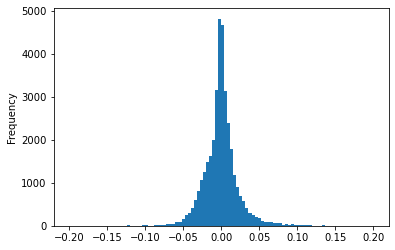

In [18]:
X['R(0,1)'].plot.hist(bins=100, range=[-0.2,0.2])

In [19]:
# Standardizes the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

X_scaled = pd.DataFrame(scaled_X, columns=X.columns, index=X.index)

In [20]:
# Handles missing data


In [21]:
def ols_model(y,x,start):
    '''
    Function to estimate a simple OLS model.
    'start' should be incremented by 12 for the model to be re-estimated every 12 months.
    '''
    Y = y.loc[y.index.levels[0][30:].values[start:start+60]]
    X = x.loc[x.index.levels[0][30:].values[start:start+60]]
    
    # Estimates the model
    model = OLS(Y,X).fit()
    
    # Model output
    Y_hat = model.predict(x.loc[x.index.levels[0][30:].values[start+60]]) # next month
    Y_true = y.loc[y.index.levels[0][30:].values[start+60]]
    Y_hat.columns = Y.columns
    
    index = y.index.levels[0][30:][start+60:start+60+12]
    
    return (Y_hat, Y_true, index)

In [22]:
def model_est(model_name,y,x,start):
    '''
    Function to train a model on the data. Outputs predicted values. 
    'start' should be incremented by 12 for the model to be re-estimated every 12 months.
    'model_name' should be 'ols', 'tree', 'forest', 'neural_net', 'xgboost'.
    '''
    Y = y.loc[y.index.levels[0][30:].values[start:start+60]]
    X = x.loc[x.index.levels[0][30:].values[start:start+60]]
    
    # Estimates the model
    if model_name=='ols':
        model = OLS(Y,X).fit()
    
    if model_name=='tree':
        model = tree(splitter='best', max_depth=100, random_state=1).fit(X,Y)
    
    if model_name=='forest':
        model = forest(n_estimators=200, max_depth=25, max_features=8, random_state=1).fit(X,Y) # based on MZ
    
    if model_name=='neural_net':
        model = neural_net(hidden_layer_sizes=(24,12,6), activation='relu', 
                           solver='sgd', random_state=1).fit(X,Y) # 3 hidden layers with neurons as per Gu, Kelly, Xiu (2019)
    
    if model_name=='xgboost':
        model = xgboost(n_estimators=200, max_depth=25, random_state=1).fit(X,Y) # similar parameters to forest
    
    # Model output
    Y_hat = model.predict(x.loc[x.index.levels[0][30:].values[start+60]]) # next month
    Y_true = y.loc[y.index.levels[0][30:].values[start+60]]
    
    if model_name=='ols':
        Y_hat.columns = Y.columns

    else:
        Y_hat = pd.DataFrame(Y_hat, columns=Y.columns, index=x.loc[x.index.levels[0][30:].values[start+60]].index)
    
    index = y.index.levels[0][30:][start+60:start+60+12]
    
    return (Y_hat, Y_true, index)

In [23]:
def index_forecast(y, y_hat, index, start):
    '''
    Function to multi-index a cross-section with the respective starting year.
    '''
    y_hat['date'] = index[0]
    y_hat = y_hat.reset_index().set_index(['date', 'issue_id'])
    
    return y_hat

In [24]:
def compute_deciles(df):
    '''
    Computes deciles of each column.
    '''
    deciles = df.apply(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=0)
    deciles.columns = df.columns+'_decile'
    
    return deciles

In [49]:
def value_weight(df, group, value, weight):
    '''
    Function to take the value-weighted average return for a particular decile.
    '''
    
    group_sum = (df[value] * df[weight]).groupby(df[group]).sum()
    group_weight = df[weight].groupby(df[group]).sum()
    
    group_weighted_avg = group_sum / group_weight
    
    return group_weighted_avg

In [202]:
def amt_out(index):
    '''
    Function to organize the amount-outstanding for the purposes of value-weighting the return.
    It takes in the index corresponding to the forecast period. 
    '''
    
    # Subsets the amount outstanding, and converts index from dates to t+k ahead return
    amt = model_data["amount_outstanding"].loc[index]
    index_return = pd.DataFrame(y_hat.columns, index=index, columns=['return'])
    amt = amt.reset_index().merge(index_return, on='date').set_index(['return','issue_id']).drop('date', axis=1)
    
    # Gets the first value
    amt = amt.unstack(-1).bfill().ffill()
    amt = amt.iloc[0].to_frame()
    amt = amt.reset_index().set_index('issue_id').drop('level_0', axis=1)
    amt.columns = ['amt_out']

    return amt

In [205]:
def trading_strategy(y_hat, y_true, index):
    '''
    Function to output results of the trading strategy.
    The inputs are the results from the model: the fitted values and the true values
    '''
    # Computes return deciles based on fitted values
    deciles = compute_deciles(y_hat)
    
    # Merges deciles with actual values
    y_deciles = pd.concat([y_true, deciles], axis=1)
    y_deciles = pd.merge(y_deciles, amt_out(index), how="left", on="issue_id")

    # Portfolio Formation
    columns = y_deciles.columns[:12]
    month_ahead_return_ew = []
    month_ahead_return_vw = []
    
    
    # Equal-weighted average
    for column in columns:
        month_ahead_return_ew.append(y_deciles.groupby(column+'_decile')[column].mean())
    
    # Value-weighted average
    for column in columns:
        gwa = value_weight(y_deciles, (column+'_decile'), column, "amt_out")
        month_ahead_return_vw.append(gwa)

    decile_portfolios = pd.concat(month_ahead_return_vw, axis=1)
    decile_portfolios.index.names = ['decile']
    
    strategy_return = decile_portfolios.T[9] - decile_portfolios.T[0]
    strategy_return.index = index
    
    return strategy_return

In [186]:
y_hat, y_true, index = ols_model(Y,X,0)

In [187]:
amt = model_data["amount_outstanding"].loc[index]
index_return = pd.DataFrame(y_hat.columns, index=index, columns=['return'])
amt = amt.reset_index().merge(index_return, on='date').set_index(['return','issue_id']).drop('date', axis=1)

In [188]:
amt = amt.unstack(-1).bfill().ffill()
amt = amt.iloc[0].to_frame()
amt = amt.reset_index().set_index('issue_id').drop('level_0', axis=1)
amt.columns = ['amt_out']

In [194]:
y_deciles = pd.concat([y_true, compute_deciles(y_hat)], axis=1)
y_deciles = pd.merge(y_deciles, amt, how="left", on=["issue_id"])

In [196]:
columns = y_deciles.columns[:12]
month_ahead_return_vw = []

for column in columns:
    gwa = value_weight(y_deciles, (column+'_decile'), column, "amt_out")
    month_ahead_return_vw.append(gwa)

In [201]:
pd.concat(month_ahead_return_vw, axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.004715,-0.032824,0.005770,0.009468,0.032325,-0.004668,0.039055,-0.012732,-0.033331,-0.027864,-0.031705,-0.021283
1,-0.000940,-0.016063,0.027732,0.003394,0.028425,0.000353,0.029333,-0.018653,-0.018444,-0.020530,-0.019666,-0.009889
2,-0.000395,-0.016670,0.019425,0.008259,0.034712,-0.005343,0.038820,-0.018360,-0.004501,-0.021947,-0.006728,-0.004203
3,0.000320,-0.017540,0.008803,0.013486,0.018747,0.007061,0.049810,-0.022461,-0.007838,-0.012235,-0.005453,-0.008580
4,0.002819,-0.012836,0.012129,0.010828,0.017557,0.008446,0.025260,-0.008511,-0.003069,-0.005127,-0.023634,-0.000321
5,-0.002622,-0.005939,0.005429,0.019254,0.008626,0.008753,0.024304,-0.009367,-0.000123,-0.015101,-0.018224,0.001921
6,0.005004,-0.005517,0.010132,0.024690,0.006593,0.003600,0.008770,0.002655,-0.005661,-0.008772,-0.021271,-0.003324
7,0.001697,-0.007240,0.014921,0.032567,0.011459,0.003944,0.025767,0.002853,-0.006369,-0.015976,-0.040014,-0.000831
8,-0.000968,-0.014309,0.014498,0.033463,0.021894,0.010653,0.010763,-0.005226,-0.002902,-0.012107,-0.034096,-0.000211
9,-0.001433,-0.000899,0.013715,0.033162,0.029325,0.003232,0.032029,-0.014217,-0.007495,-0.010027,-0.023934,-0.001835


In [207]:
# Value weight
trading_strategy(y_hat, y_true, index)

date
2010-01-31    0.003282
2010-02-28    0.031924
2010-03-31    0.007945
2010-04-30    0.023695
2010-05-31   -0.003000
2010-06-30    0.007900
2010-07-31   -0.007026
2010-08-31   -0.001485
2010-09-30    0.025836
2010-10-31    0.017837
2010-11-30    0.007770
2010-12-31    0.019448
dtype: float64

In [26]:
def out_of_sample_procedure(model_name,y,x):
    '''
    Function to run the rolling annual model training and forecasting.
    Outputs the trading strategy return as well as the fitted values for each both for each month.
    'model_name' should be 'ols', 'tree', 'forest', 'neural_net', 'xgboost'.
    '''
    strat_returns = []
    actual_y = []
    forecast_y = []
    
    for step in np.arange(0,len(X.index.levels[0][30:].unique()),12)[:11]:
        y_hat, y_true, index = model_est(model_name, y, x, step)
        model = trading_strategy(y_hat, y_true, index)
        
        strat_returns.append(model)
        actual_y.append(index_forecast(y, y_true, index, step))
        forecast_y.append(index_forecast(y, y_hat, index, step))
        
    strat_returns_df = pd.concat(strat_returns)
    actual_y_df= pd.concat(actual_y)
    forecast_y_df = pd.concat(forecast_y)
    
    return (strat_returns_df, actual_y_df, forecast_y_df)

In [28]:
from sklearn.metrics import r2_score as R2

In [29]:
returns, y_true, y_hat = out_of_sample_procedure('ols',Y,X)

<AxesSubplot:xlabel='date'>

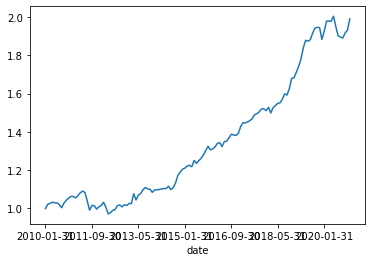

In [30]:
(1+returns).cumprod().plot()

In [31]:
R2(y_true,y_hat)

-0.07181073108448154

In [35]:
returns_nn, y_true_nn, y_hat_nn = out_of_sample_procedure('neural_net',Y,X)

<AxesSubplot:xlabel='date'>

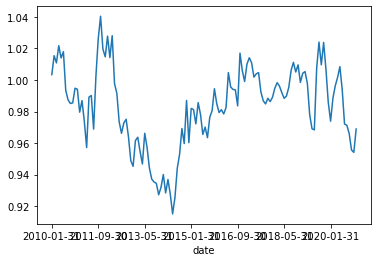

In [36]:
(1+returns_nn).cumprod().plot()

In [37]:
R2(y_true_nn,y_hat_nn)

-0.04616042807650039

In [40]:
# # OLS Model Output
# from linearmodels.system.model import SUR
# model = SUR.multivariate_ls(Y, X).fit(cov_type='kernel', kernel='bartlett')
# print(model)

## Hyperparameter Tuning: Cross-Validation & GridSearch

Since we are working with unbalanced panel data, that is for every month we have a cross-section of bonds (which potentially differ each month), sklearn does not have a built-in cross-validation splitter which is appropriate for this type of data. Hence it is crucial to create a cross-validation splitter object which adheres to the principal of a time-series splitter (ie. not train on future data), while also being mindful of the cross-sectional dimension.

More generally with respect to cross-validation, the models and forecasts are computed on a rolling basis; this is akin to a rolling time-series cross-validation. The model is re-estimated every year, with data from the past 5 years. So it makes sense to incorporate a 5 fold time-series split; train on 1 year, validate on 1 (then train on 2, validate on the next etc). However this is computationally cumbersome since it would require grid searching 17 times (ie. every time a model is estimated). In particular due to the rolling nature, only 20% of the sample (ie. 1/5 years) will be "new" data, so potentially there will be similarity in the optimal hyperparameters across models. 

Therefore a sensible hyperparameter tuning strategy would be to initially tune the model, and keep those same hyperparameter estimates the same for the remainder of the sample. Another strategy would be to tune the model every 5 years, so that the cross-validation data is always fresh.

In [143]:
def cv_splitter(df):
    train = df.sort_values(by='date', ascending=True).reset_index()    

    month_index = []
    for month in train['date'].unique(): 
        month_index.append(train[train['date'] == month].shape[0])
    month_index = pd.DataFrame(month_index, index=train['date'].unique(), columns=['month_index'])
    month_index = month_index.cumsum()

    return [[list(range(0,month_index.iloc[i][0])), 
                        list(range(month_index.iloc[i][0],month_index.iloc[i+2][0]))] 
                           for i in np.arange(12,60,12)]

In [142]:
# split = cv_splitter(X)

In [139]:
# split[0][0]
# split[0][1]

##### For Christie:

In [113]:
train = X.sort_values(by='date', ascending=True).reset_index()    

month_index = []
for month in train['date'].unique(): 
    month_index.append(train[train['date'] == month].shape[0])
month_index = pd.DataFrame(month_index, index=train['date'].unique(), columns=['month_index'])
month_index = month_index.cumsum()

split = [[list(range(0,month_index.iloc[i][0])), 
                    list(range(month_index.iloc[i][0],month_index.iloc[i+12][0]))] 
                       for i in np.arange(12,60,12)]

In [114]:
# Cummulative # of bonds for each month
month_index

,month_index
2005-01-31,98
2005-02-28,196
2005-03-31,297
2005-04-30,402
2005-05-31,502
...,...
2020-08-31,34962
2020-09-30,35211
2020-10-31,35447
2020-11-30,35657


In [115]:
# total number of bonds in month 12 
month_index.iloc[12][0]

1404

In [116]:
# Verify the # of rows in the first 12 months of the dataset
X.loc[:'2006-02']

R(0,1)    R(1,1)    R(2,1)    R(3,1)    R(4,1)  \
date       issue_id                                                     
2005-01-31 38        0.286900  0.392811  0.090582  0.007757  0.016853   
           54        0.231370  0.326054  0.148467  0.067422  0.002623   
           96        0.085493  0.066137  0.094480  0.029760  0.100990   
           173       0.060104  0.088349  0.037665 -0.009417  0.134515   
           175       0.089175  0.055734  0.076489  0.075762  0.059755   
...                       ...       ...       ...       ...       ...   
2006-01-31 174428    0.061806  0.032128  0.051783  0.052054  0.062796   
           174433    0.070120  0.043819  0.051750  0.030649  0.100945   
           176236    0.059031  0.059293  0.035278  0.034725  0.073128   
           176237    0.055501  0.067891  0.037748  0.017949  0.082798   
           177623    0.114490  0.056726  0.092648  0.099250  0.093091   

                       R(5,1)    R(6,1)    R(7,1)    R(8,1)    R(9,1)  ...  \
date       issue_id                                                    ...   
2005-01-31 38        0.030916  0.203523  0.038931  0.139797 -0.047095  ...   
           54        0.010135  0.155252  0.019478  0.118495  0.034013  ...   
           96        0.067290  0.044863  0.092494  0.030475  0.021483  ...   
           173       0.078055  0.080772  0.031888  0.028691  0.028012  ...   
           175       0.056975  0.041182  0.093901  0.062940  0.048435  ...   
...                       ...       ...       ...       ...       ...  ...   
2006-01-31 174428    0.056090  0.067017  0.017253  0.070506  0.046974  ...   
           174433    0.052958  0.072947  0.039181  0.098659  0.042330  ...   
           176236    0.009874  0.059301  0.058210  0.071140  0.034817  ...   
           176237    0.046180  0.049477  0.077858  0.030423  0.046067  ...   
           177623    0.087828  0.174867  0.078491  0.031083  0.059127  ...   

                      R(14,1)   R(15,1)   R(16,1)   R(17,1)   R(18,1)  \
date       issue_id                                                     
2005-01-31 38        0.255630  0.194802  0.120720  0.040227  0.576254   
           54        0.222012  0.238974  0.055021  0.133504  0.503291   
           96        0.078006  0.066975  0.055521  0.064080  0.067257   
           173       0.063895  0.059220  0.069183 -0.001552  0.046521   
           175       0.078216  0.095595  0.045082  0.007242  0.048845   
...                       ...       ...       ...       ...       ...   
2006-01-31 174428    0.065171  0.058082  0.063878  0.073532  0.064840   
           174433    0.080077  0.058320  0.095279  0.091955  0.074646   
           176236    0.053722  0.064465  0.085302  0.046695  0.057847   
           176237    0.087608  0.101432  0.091749  0.033094  0.037943   
           177623    0.152343  0.077765  0.073385 -0.033525  0.098591   

                      R(19,1)   R(20,1)   R(21,1)   R(22,1)   R(23,1)  
date       issue_id                                                    
2005-01-31 38        0.362272  1.486548  0.096401  0.123870 -0.184631  
           54        0.357057  1.519604  0.432816 -0.059902 -0.228833  
           96        0.113711  0.089054  0.056338  0.066614  0.074679  
           173       0.124194  0.089841  0.021358  0.077881  0.043703  
           175       0.121171  0.089294  0.065060  0.045432  0.072661  
...                       ...       ...       ...       ...       ...  
2006-01-31 174428    0.005080  0.029800  0.064078  0.054358  0.071152  
           174433   -0.006665  0.032841  0.073254  0.080818  0.086660  
           176236    0.041119  0.001309  0.062836  0.067235  0.039510  
           176237    0.007264  0.074531  0.076802  0.077960  0.053508  
           177623    0.020550  0.046199  0.054689  0.062322  0.065656  

[1404 rows x 24 columns]

In [126]:
# first split starts at 0
split[0][0][0]

0

In [127]:
# first split end at 1403
split[0][0][-1]

1403

In [128]:
# second split starts at 1404
split[0][1][0]

1404

In [138]:
X.loc[:'2009-02']

R(0,1)    R(1,1)    R(2,1)    R(3,1)    R(4,1)  \
date       issue_id                                                     
2005-01-31 38        0.286900  0.392811  0.090582  0.007757  0.016853   
           54        0.231370  0.326054  0.148467  0.067422  0.002623   
           96        0.085493  0.066137  0.094480  0.029760  0.100990   
           173       0.060104  0.088349  0.037665 -0.009417  0.134515   
           175       0.089175  0.055734  0.076489  0.075762  0.059755   
...                       ...       ...       ...       ...       ...   
2009-01-31 357580    0.210372  0.132090 -0.054827 -0.010666  0.071404   
           359188    0.111149  0.111672 -0.033871  0.002739  0.039357   
           359192    0.103189  0.153232  0.010980 -0.113773  0.023172   
           365559    0.145164  0.680812 -0.144864 -0.324571  0.010373   
           365561    0.227660  0.679886 -0.210568 -0.298071 -0.038569   

                       R(5,1)    R(6,1)    R(7,1)    R(8,1)    R(9,1)  ...  \
date       issue_id                                                    ...   
2005-01-31 38        0.030916  0.203523  0.038931  0.139797 -0.047095  ...   
           54        0.010135  0.155252  0.019478  0.118495  0.034013  ...   
           96        0.067290  0.044863  0.092494  0.030475  0.021483  ...   
           173       0.078055  0.080772  0.031888  0.028691  0.028012  ...   
           175       0.056975  0.041182  0.093901  0.062940  0.048435  ...   
...                       ...       ...       ...       ...       ...  ...   
2009-01-31 357580    0.040131  0.064418  0.028312  0.086222  0.016586  ...   
           359188    0.058634  0.056189  0.039236  0.055558  0.041193  ...   
           359192    0.056333  0.056599  0.030913  0.069826  0.049789  ...   
           365559    0.074758  0.041914  0.047701  0.025976  0.066951  ...   
           365561    0.058237  0.028189  0.031384  0.031567  0.055043  ...   

                      R(14,1)   R(15,1)   R(16,1)   R(17,1)   R(18,1)  \
date       issue_id                                                     
2005-01-31 38        0.255630  0.194802  0.120720  0.040227  0.576254   
           54        0.222012  0.238974  0.055021  0.133504  0.503291   
           96        0.078006  0.066975  0.055521  0.064080  0.067257   
           173       0.063895  0.059220  0.069183 -0.001552  0.046521   
           175       0.078216  0.095595  0.045082  0.007242  0.048845   
...                       ...       ...       ...       ...       ...   
2009-01-31 357580    0.016396  0.056771  0.080653  0.034362  0.041428   
           359188    0.083934  0.036487  0.072494  0.070176  0.054615   
           359192    0.101631  0.052162  0.082185  0.078072  0.057323   
           365559    0.040985  0.048173  0.073209  0.060618  0.054604   
           365561    0.038725  0.052994  0.069672  0.071114  0.043724   

                      R(19,1)   R(20,1)   R(21,1)   R(22,1)   R(23,1)  
date       issue_id                                                    
2005-01-31 38        0.362272  1.486548  0.096401  0.123870 -0.184631  
           54        0.357057  1.519604  0.432816 -0.059902 -0.228833  
           96        0.113711  0.089054  0.056338  0.066614  0.074679  
           173       0.124194  0.089841  0.021358  0.077881  0.043703  
           175       0.121171  0.089294  0.065060  0.045432  0.072661  
...                       ...       ...       ...       ...       ...  
2009-01-31 357580    0.058275  0.017706  0.080240  0.040266  0.069998  
           359188    0.042109  0.069812  0.023139  0.086711  0.047850  
           359192    0.039472  0.085075  0.003196  0.105256  0.038409  
           365559    0.043864  0.033238  0.050060  0.071174  0.040461  
           365561    0.035533  0.038281  0.050211  0.077814  0.049731  

[5961 rows x 24 columns]

In [133]:
# last split starts at 0
split[3][0][0]

0

In [132]:
# last split ...
split[3][0][-1]

5960

In [135]:
# last split ...
split[3][1][0]

5961

In [136]:
# 
len(split)

4

## X